In [34]:
import sklearn.datasets
import umap
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import hdbscan

In [2]:
execfile('functions/data_specifics.py')
execfile('functions/graph_functions.py')
print(data_set_list)

['pendigits', 'coil', 'mnist', 'usps', 'buildings', 'clusterable']


In [3]:
digits = sklearn.datasets.load_digits()

In [4]:
import seaborn as sns
from sklearn.manifold import TSNE

In [5]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score

In [6]:
from scipy.stats import mode
def measure_refinement(reference, test_partition):
    ind_max = max(test_partition)+1
    ind_min = min(test_partition)
    not_in_dominant = 0
    for grp in range(ind_min,ind_max):
        sublabels = reference[test_partition==grp]
        sizeLarge = mode(sublabels)[1][0]
        not_in_dominant = not_in_dominant + (len(sublabels)-sizeLarge)
    return(1 - not_in_dominant/len(reference))

In [7]:
def eval_clusters(cluster_labels0, true_labels, raw_data, cluster_method="None", min_cluster_size=1):
    cluster_labels = cluster_labels0.copy()
    unique_labels = np.unique(cluster_labels)
    cluster_sizes, size_ids = np.histogram(cluster_labels, bins=unique_labels)
    if np.any(cluster_sizes <= min_cluster_size): # Has singleton clusters -- call them noise
        singleton_clusters = size_ids[:-1][cluster_sizes < min_cluster_size]
        for c in singleton_clusters:
            cluster_labels[cluster_labels == c] = -1
    if (np.any(cluster_labels < 0)): # Has noise points
        clustered_points = (cluster_labels >= 0)
        ari = adjusted_rand_score(true_labels[clustered_points], cluster_labels[clustered_points])
        ami = adjusted_mutual_info_score(true_labels[clustered_points], cluster_labels[clustered_points])
        sil = silhouette_score(raw_data[clustered_points], cluster_labels[clustered_points])
        pct_clustered = (np.sum(clustered_points) / cluster_labels.shape[0])
        #print(f"ARI: {ari:.4f}\nAMI: {ami:.4f}\nSilhouette: {sil:.4f}\nPct clustered: {pct_clustered * 100:.2f}%")
    else:
        ari = adjusted_rand_score(true_labels, cluster_labels)
        ami = adjusted_mutual_info_score(true_labels, cluster_labels)
        sil = silhouette_score(raw_data, cluster_labels)
        #print(f"ARI: {ari:.4f}\nAMI: {ami:.4f}\nSilhouette: {sil:.4f}")
        pct_clustered = 1.0
    
    return {"Method": cluster_method, "ARI": ari, "AMI": ami, "Silhouette": sil, "Pct Clustered": pct_clustered}

In [8]:
def evaluation_dataframe(cluster_labels, true_labels, raw_data, min_cluster_size=1):
    eval_results = pd.DataFrame(
        [
            eval_clusters(algo_labels, true_labels, raw_data, cluster_method=algo, min_cluster_size=min_cluster_size)
            for algo, algo_labels in cluster_labels.items() 
        ]
    )
    return(eval_results)

In [29]:
raw_data = digits.data

In [9]:
tsne_map = TSNE().fit_transform(digits.data)

/disk/home/vmpouli/.conda/envs/HighDimensionalClustering/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/disk/home/vmpouli/.conda/envs/HighDimensionalClustering/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [10]:
symmetric_graph, _, _ = umap.umap_.fuzzy_simplicial_set(digits.data, n_neighbors=15, metric="euclidean", random_state=42)
# symmetric_graph[np.arange(symmetric_graph.shape[0]), np.arange(symmetric_graph.shape[0])] = 1.0
umap_graph = symmetric_graph.copy()
directed_graph, _, _ = umap.umap_.fuzzy_simplicial_set(digits.data, n_neighbors=15, metric="euclidean", random_state=42, apply_set_operations=False)
directed_graph = directed_graph.tocsr()

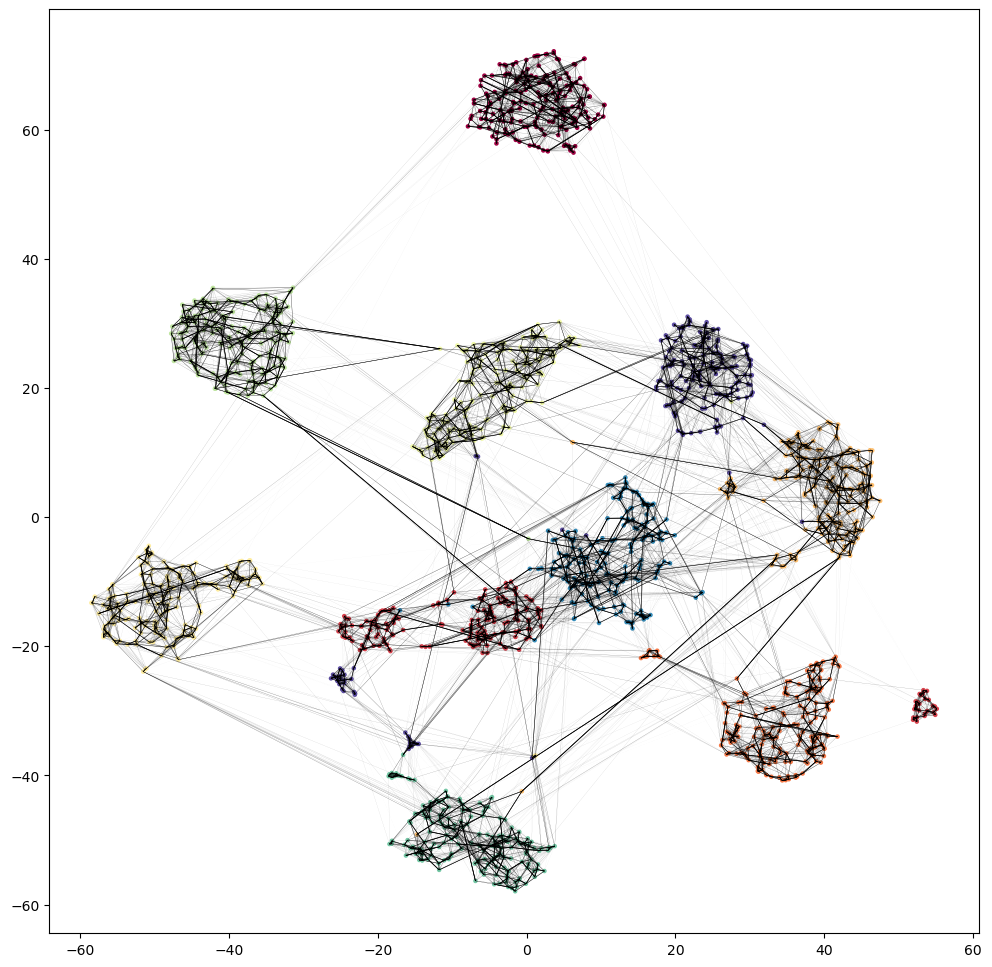

In [14]:
fig, ax = plt.subplots(figsize=(12,12))
coo_umap_graph = umap_graph.tocoo()
edges = LineCollection(
    np.dstack([tsne_map[coo_umap_graph.row], tsne_map[coo_umap_graph.col]]).transpose((0, 2, 1)), 
    linewidths=0.5 * coo_umap_graph.data, 
    colors=np.vstack([np.zeros((3, coo_umap_graph.data.shape[0])), coo_umap_graph.data]).T,
    zorder=3
)
ax.add_collection(edges)
# for idx in range(coo_umap_graph.row.shape[0]):
#     i, j, weight = coo_umap_graph.row[idx], coo_umap_graph.col[idx], coo_umap_graph.data[idx]
#     ax.plot(map.T[0][[i, j]], map.T[1][[i, j]], lw=weight*0.5, c='k', alpha=weight)
ax.scatter(*tsne_map.T, s=5, c=digits.target, cmap="Spectral")
fig.savefig('figures/graph_display_labelled_nodes_pendigits.png', bbox_inches='tight')

In [15]:
from sklearn.preprocessing import normalize
import scipy.sparse.csgraph
import igraph as ig
import leidenalg as la

In [17]:
umap_graph = normalize(directed_graph, norm="l1")
new_graph = umap_graph * umap_graph# + umap_graph
new_graph.setdiag(0)
new_graph = normalize(new_graph, norm="l1")
new_graph.data[new_graph.data < 0.001] = 0.0
new_graph = normalize(new_graph, norm="l1")
new_graph.eliminate_zeros()
new_graph = new_graph + new_graph.T - new_graph.multiply(new_graph.T)
# new_graph = new_graph.maximum(new_graph.T)

clustering_labels = dict()
for i in range(11):
    if(i % 5 ==0):
        G = ig.Graph.Weighted_Adjacency(new_graph, 'undirected')
        clusterings = np.array(la.find_partition(G, la.ModularityVertexPartition).membership)
        clustering_labels[i] = clusterings
        
    new_graph = umap_graph * new_graph# + umap_graph
    # new_graph = new_graph * umap_graph
    new_graph.setdiag(0)
    new_graph = normalize(new_graph, norm="l1")
    new_graph.data[new_graph.data < 0.001] = 0.0
    new_graph = normalize(new_graph, norm="l1")
    new_graph.eliminate_zeros()
    new_graph = new_graph + new_graph.T - new_graph.multiply(new_graph.T)

    # new_graph = new_graph.maximum(new_graph.T)
    
new_graph = new_graph ** 3
new_graph.data[new_graph.data < 0.001] = 0.0
new_graph.eliminate_zeros()
G = ig.Graph.Weighted_Adjacency(new_graph, 'undirected')
clusterings = np.array(la.find_partition(G, la.ModularityVertexPartition).membership)
clustering_labels[i+1] = clusterings

In [18]:
import pandas as pd

In [19]:
dataset_id=0
raw_data, targets, dataset_name = get_dataset(dataset_id)

In [20]:
umap_rep = get_umap_vectors(dataset_id=dataset_id, raw_data=raw_data)
hd_umap_labels = h_dbscan(umap_rep, which_algo='hdbscan', dataset_id=dataset_id)
ari = adjusted_rand_score(targets, hd_umap_labels)

In [21]:
graph_results = evaluation_dataframe(clustering_labels, digits.target, digits.data, min_cluster_size=5)
graph_results = graph_results.rename(columns={'Method':'Threshold'})
graph_results['Baseline'] = ari
graph_results['Dataset'] = dataset_name

In [22]:
for i in range(0, 11, 5):
    print(i, measure_refinement(targets, clustering_labels[i]))

0 0.9020589872008904
5 0.8614357262103506
10 0.8747913188647747


In [24]:
for i in range(0, 11, 5):
    print(i, max(clustering_labels[i]))

0 10
5 8
10 9


In [25]:
clustering_labels

{0: array([3, 0, 0, ..., 0, 8, 0]),
 5: array([3, 0, 0, ..., 0, 8, 0]),
 10: array([4, 0, 0, ..., 0, 8, 0]),
 11: array([5, 0, 0, ..., 0, 1, 0])}

In [26]:
def plot_graph_data(adjacency_csr, layout, node_labels, thickness=0.5):
    fig, ax = plt.subplots(figsize=(12,12))
    coo_umap_graph = adjacency_csr.tocoo()
    edges = LineCollection(
        np.dstack([layout[coo_umap_graph.row], layout[coo_umap_graph.col]]).transpose((0, 2, 1)), 
        linewidths=thickness * coo_umap_graph.data, 
        colors=np.vstack([np.zeros((3, coo_umap_graph.data.shape[0])), coo_umap_graph.data]).T,
        zorder=3
    )
    ax.add_collection(edges)
    # for idx in range(coo_umap_graph.row.shape[0]):
    #     i, j, weight = coo_umap_graph.row[idx], coo_umap_graph.col[idx], coo_umap_graph.data[idx]
    #     ax.plot(map.T[0][[i, j]], map.T[1][[i, j]], lw=weight*0.5, c='k', alpha=weight)
    ax.scatter(*layout.T, s=5, c=node_labels, cmap="Spectral")
    return(fig)

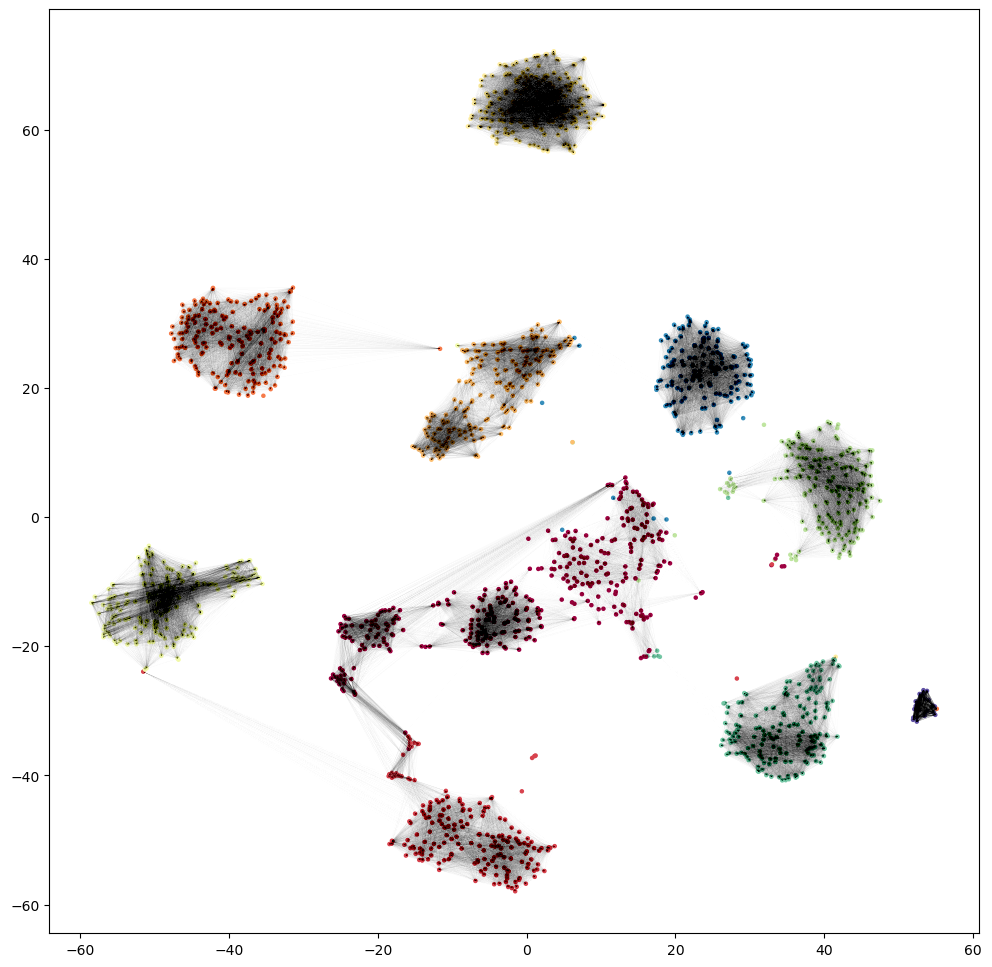

In [28]:
test = plot_graph_data(new_graph, tsne_map, clustering_labels[10], thickness=1)

# Spectral embedding of resulting graph

In [42]:
spectral_layout = umap.spectral.spectral_layout(data=raw_data,
                             graph = new_graph,
                             dim = 2,
                            random_state=42)

In [35]:
new_labels = hdbscan.HDBSCAN(min_cluster_size=15).fit_predict(spectral_layout)

In [40]:
from collections import Counter
Counter(new_labels)

Counter({1: 178,
         13: 94,
         -1: 149,
         10: 156,
         2: 177,
         5: 143,
         8: 176,
         12: 123,
         11: 57,
         3: 167,
         4: 183,
         7: 46,
         6: 102,
         9: 19,
         0: 27})

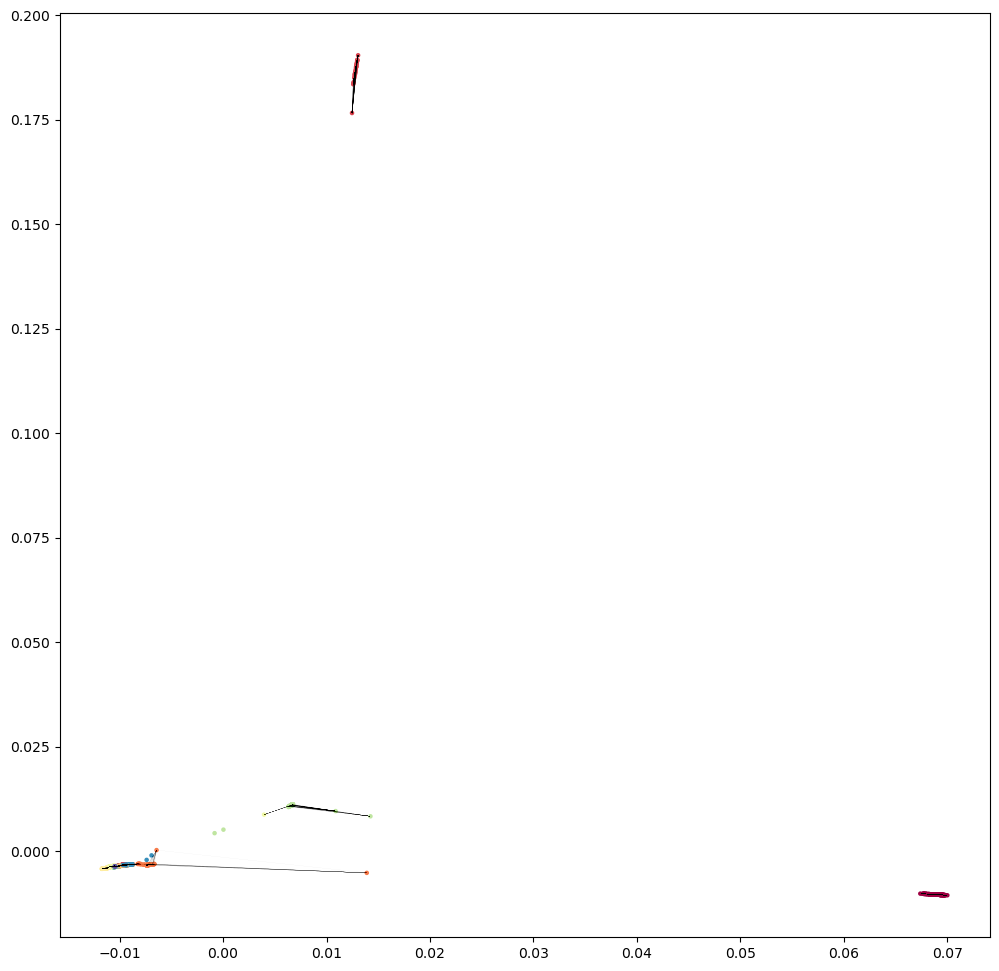

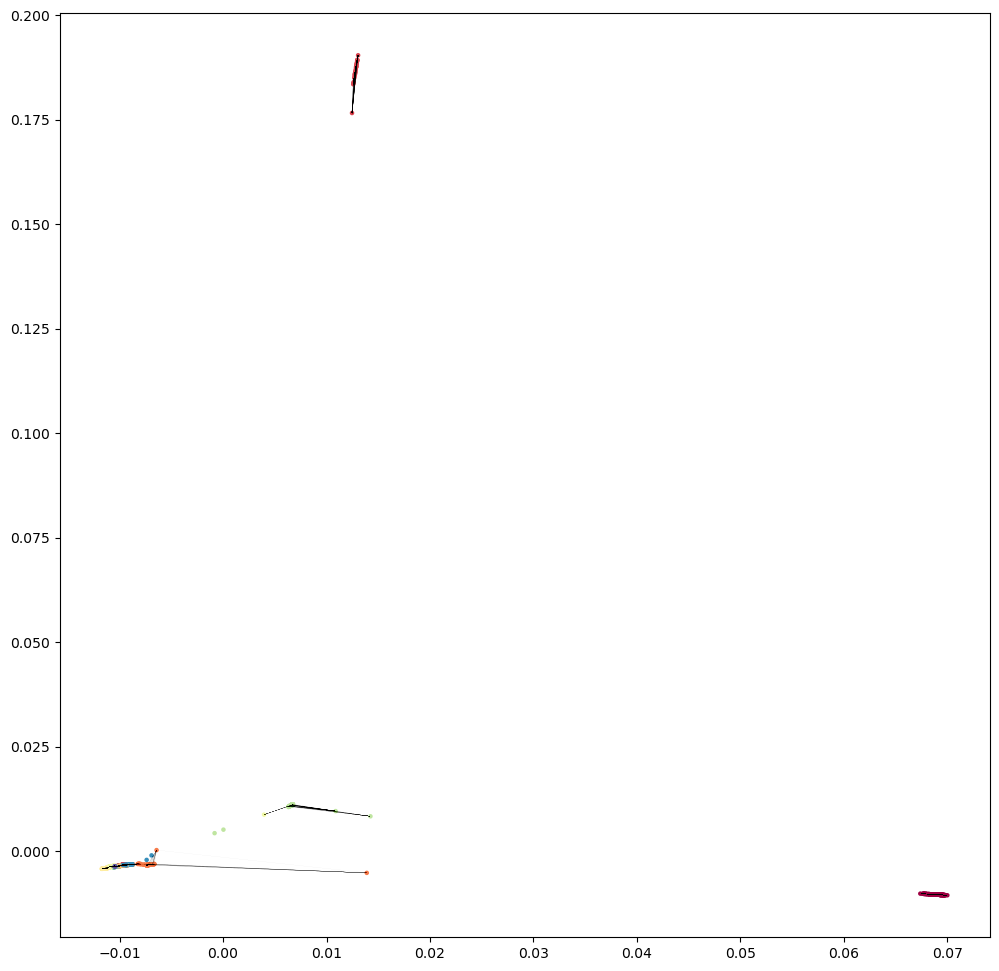

In [44]:
plot_graph_data(new_graph, spectral_layout, targets, thickness=1)

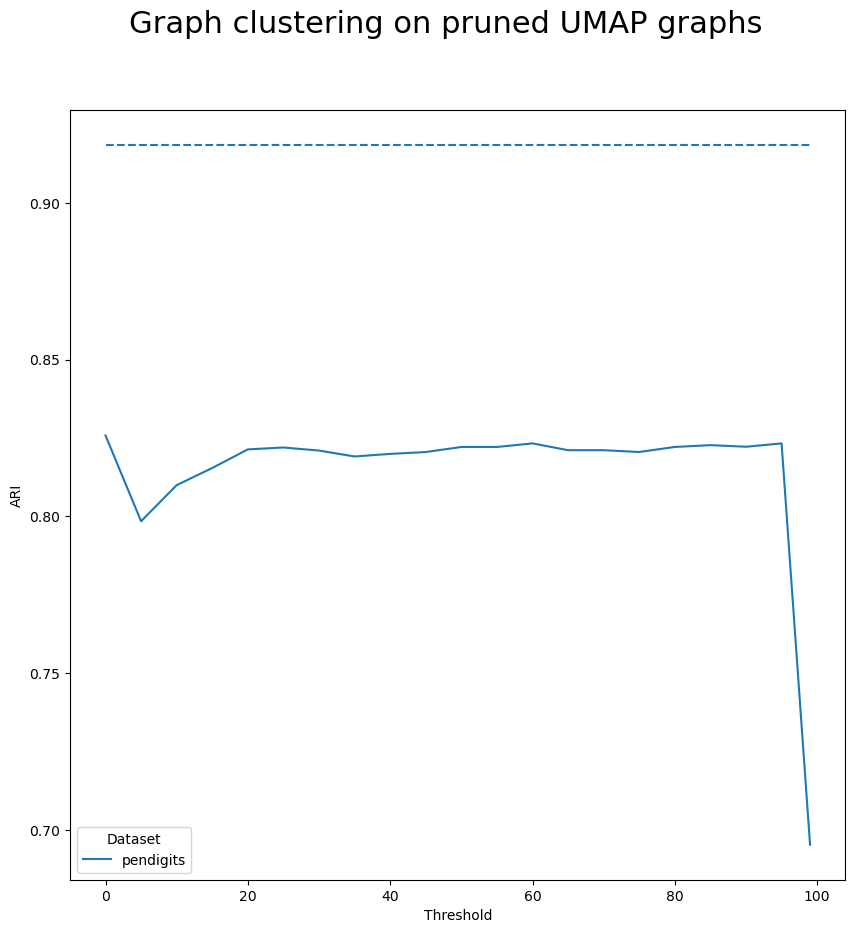

In [39]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Graph clustering on pruned UMAP graphs', fontsize=22)
ax = sns.lineplot(data=graph_results, x='Threshold', y='ARI', hue='Dataset')
ax = sns.lineplot(data=graph_results, x='Threshold', y='Baseline', hue='Dataset', legend=None, linestyle='--')
# plt.savefig(f'figures/thresholded_graph_clustering_diffusion_weight.png')

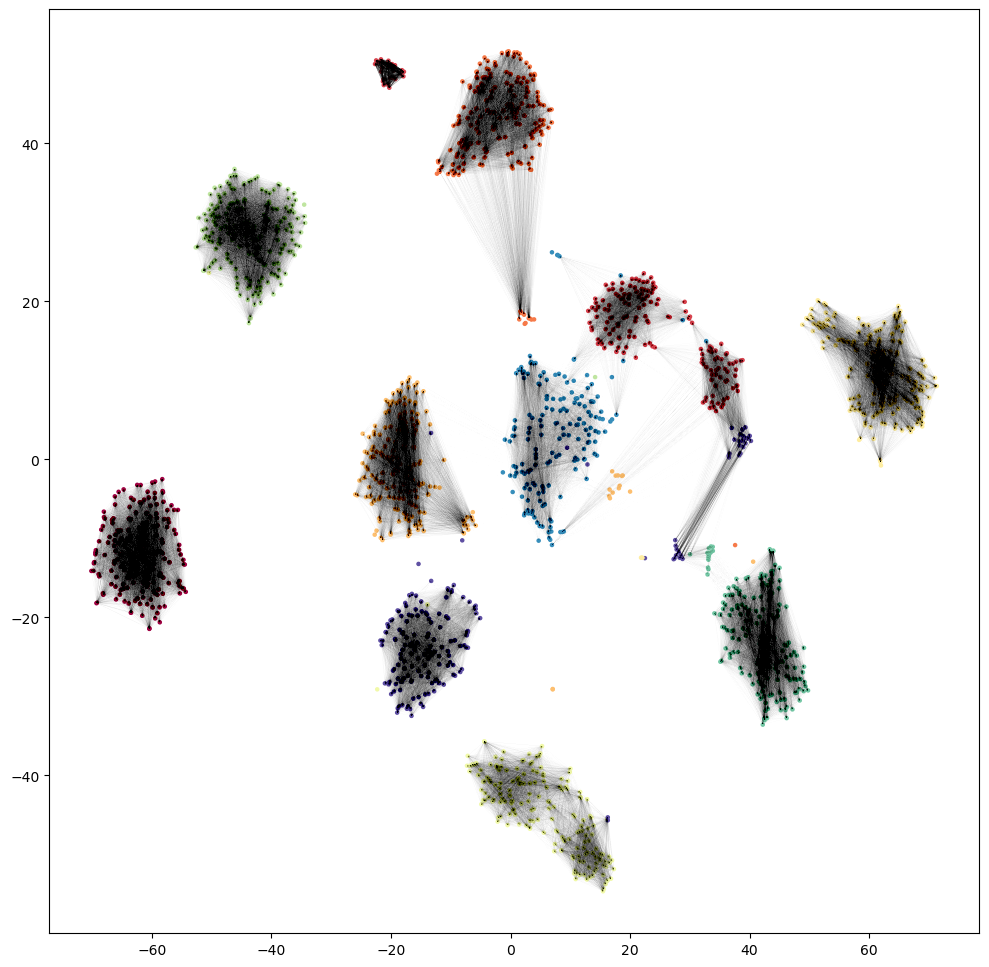

In [119]:
test = plot_graph_data(new_graph, tsne_map, , thickness=1)

In [110]:
triangle_graph = get_triangle_similarity(new_graph)
# triangle_graph = normalize(triangle_graph, norm="l1")
# triangle_graph.data[triangle_graph.data < 0.00001] = 0.0

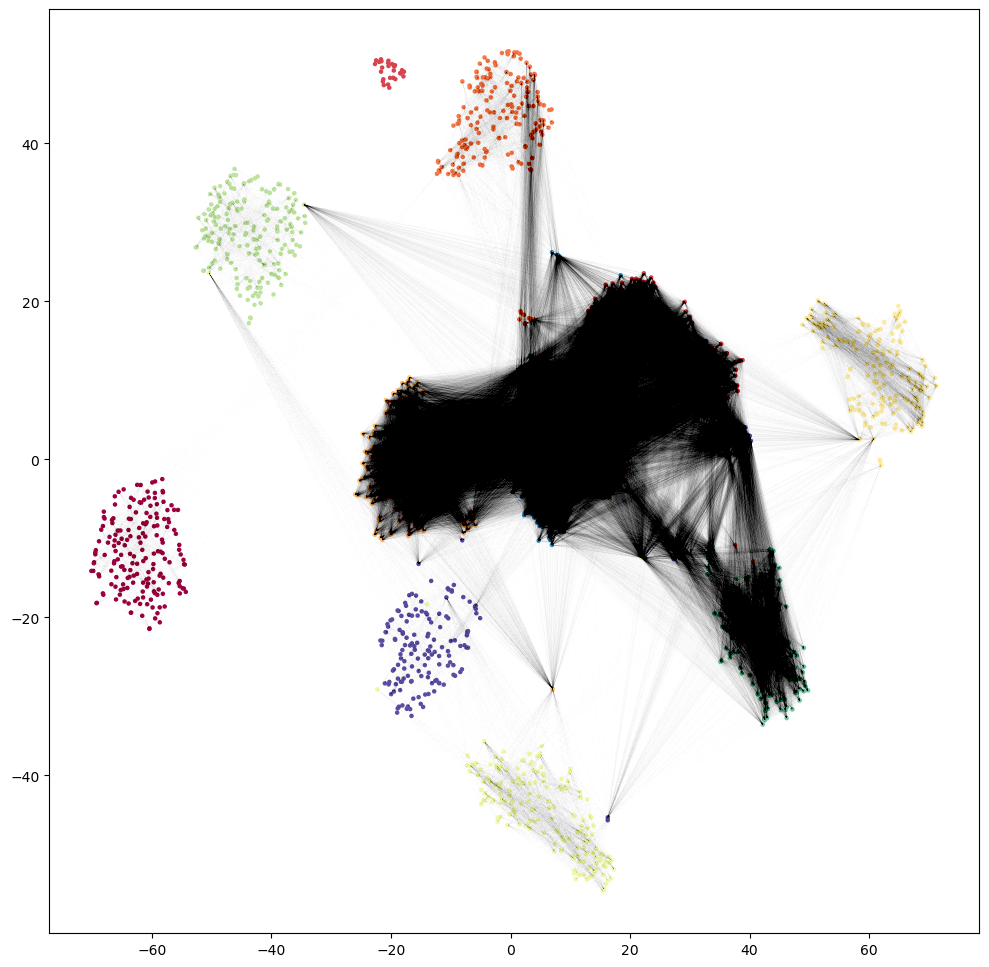

In [117]:
test = plot_graph_data(triangle_graph, tsne_map, digits.target, thickness=0.02)

In [85]:
distance_graph = new_graph.copy()
# distance_graph = distance_graph + distance_graph * distance_graph + distance_graph * distance_graph * distance_graph
# distance_graph = distance_graph * distance_graph
print(np.sum(distance_graph.data > 1))
distance_graph.eliminate_zeros()
distance_graph.data = -np.log(distance_graph.data)

0


In [739]:
import hdbscan

# HDBSCAN on sparse matrix

If the graph is not connected, do the following:
* Connected components that are not larger than 90 form their own clusters
* HDBSCAN is run on each single cluster. The "allow_single_cluster" option is turned to on if the components is of size less than 300.

In [ ]:
def hdbscan_on_sparse_distance(distance_graph, no_split_component_size=90, )

In [90]:
if scipy.sparse.csgraph.connected_components(distance_graph)[0] > 1:
    n_components, components = scipy.sparse.csgraph.connected_components(distance_graph)
    rj_labels = np.full(distance_graph.shape[0], -1, dtype=np.int64)
    for i in range(n_components):
        if np.sum(components == i) <= 90:
            subgraph_labels = np.zeros(np.sum(components == i), dtype=np.int64)
        else:
            subgraph = distance_graph[components == i, :][:, components == i]
            subgraph_labels = hdbscan.HDBSCAN(metric="precomputed", min_samples=2, min_cluster_size=30, allow_single_cluster=subgraph.shape[0] < 300).fit_predict(subgraph)
        subgraph_labels[subgraph_labels >= 0] += (rj_labels.max() + 1)
        rj_labels[components == i] = subgraph_labels
else:
    rj_labels = hdbscan.HDBSCAN(metric="precomputed", min_samples=2, min_cluster_size=30).fit_predict(distance_graph)

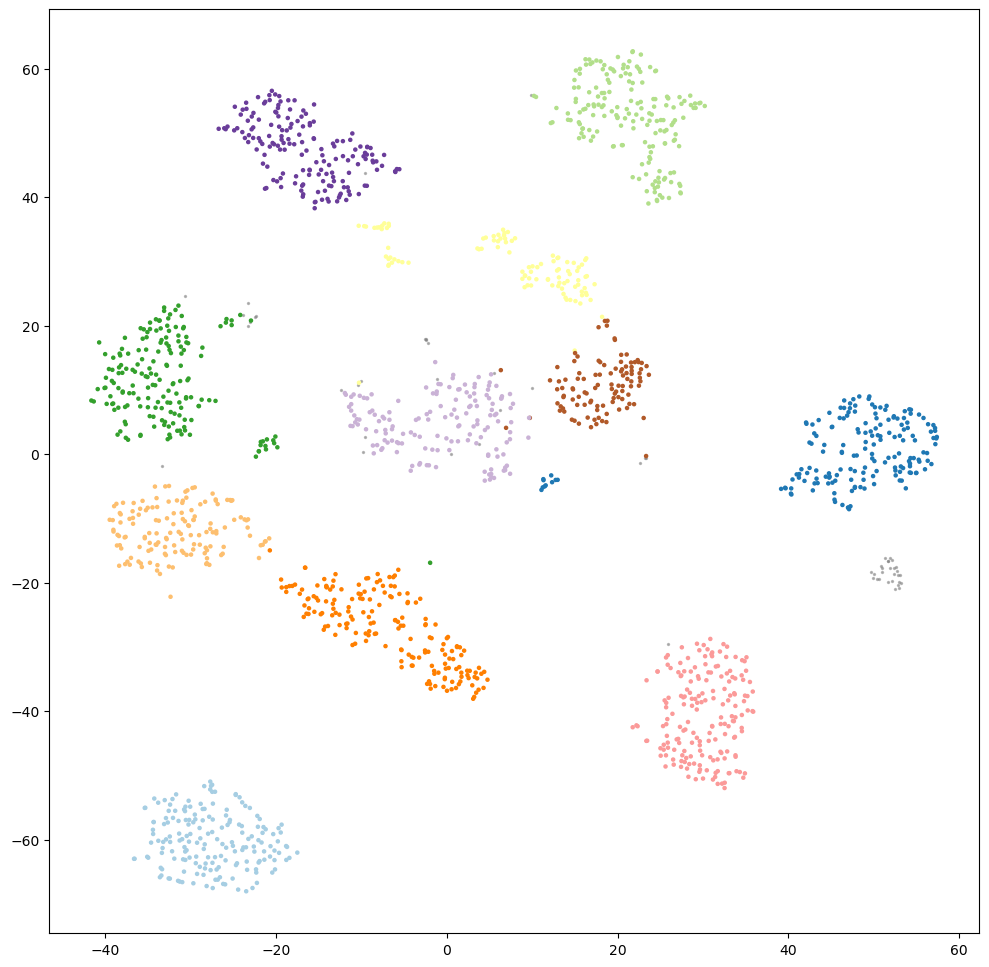

In [91]:
fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(*tsne_map[rj_labels< 0].T, s=2, c="gray", alpha=0.5)
ax.scatter(*tsne_map[rj_labels >= 0].T, s=5, c=rj_labels[rj_labels >= 0], cmap="Paired")

In [742]:
sklearn.metrics.adjusted_rand_score(digits.target, rj_labels)

0.8888344281072982

In [743]:
sklearn.metrics.adjusted_mutual_info_score(digits.target, rj_labels)

0.9073597931629132

In [616]:
uhdb_labels = hdbscan.HDBSCAN().fit_predict(umap.UMAP().fit_transform(digits.data))

In [617]:
sklearn.metrics.adjusted_rand_score(digits.target, uhdb_labels)

0.7794991195761306

In [618]:
sklearn.metrics.adjusted_mutual_info_score(digits.target, uhdb_labels)

0.8388046663513906

In [87]:
import hdbscan

In [88]:
clusterer = hdbscan.HDBSCAN(metric="precomputed", min_samples=2, min_cluster_size=30).fit(distance_graph)

<AxesSubplot:ylabel='$\\lambda$ value'>

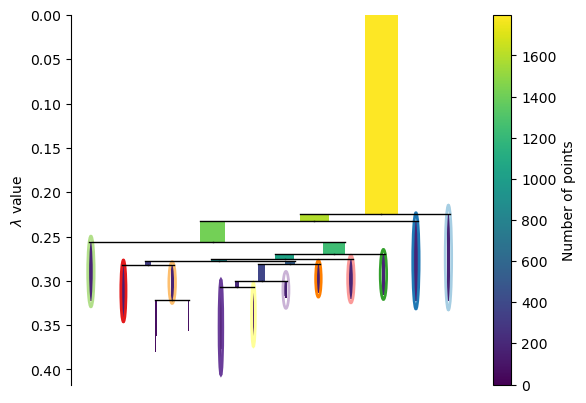

In [92]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette("Paired", np.max(rj_labels) + 1))

# Thresholded UMAP graph

In [29]:
symmetric_larger_graph, _, _ = umap.umap_.fuzzy_simplicial_set(digits.data, n_neighbors=30, metric="euclidean", random_state=42)
# symmetric_graph[np.arange(symmetric_graph.shape[0]), np.arange(symmetric_graph.shape[0])] = 1.0

In [34]:
new_larger_graph = symmetric_larger_graph.copy()
new_larger_graph.data[new_larger_graph.data < 0.2] = 0.0
new_larger_graph.eliminate_zeros()

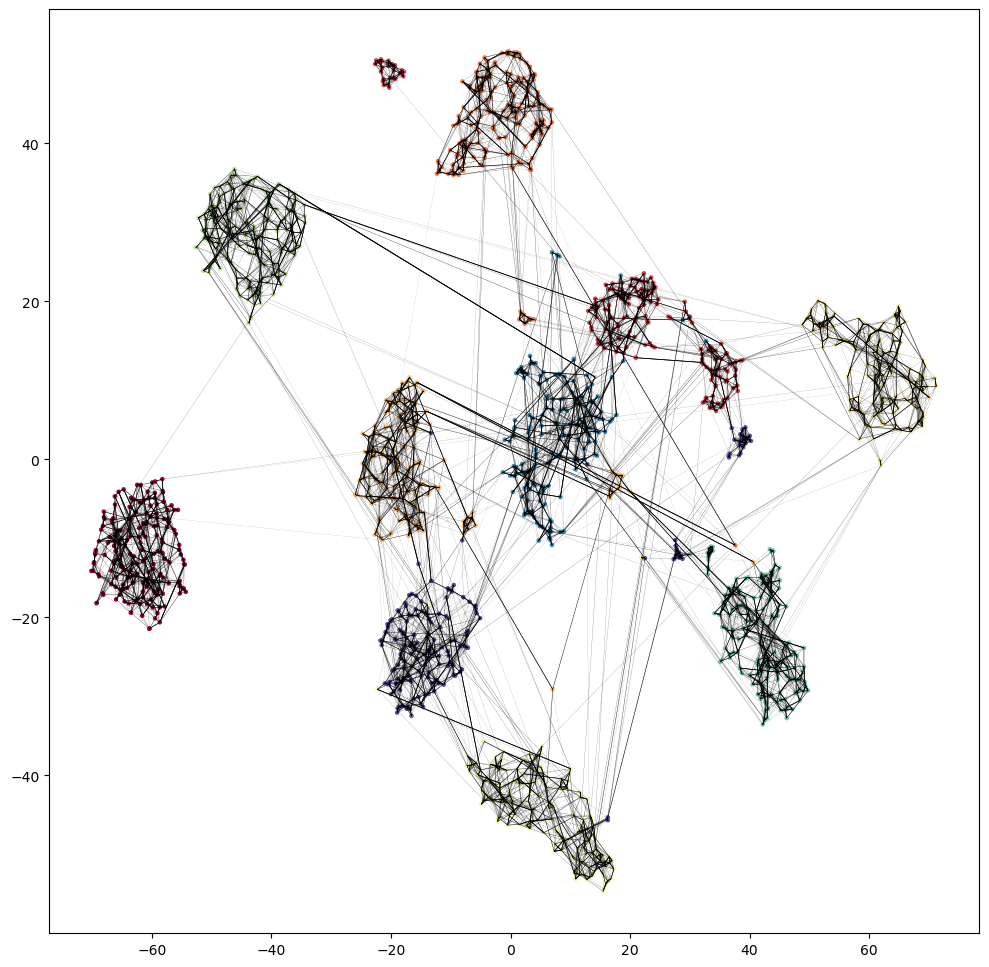

In [37]:
test = plot_graph_data(new_larger_graph, tsne_map, digits.target)

# Triangle and neighborhood amplification

In [38]:
# Romeo and Juliet: each edge weights is replaced by the average of weights (including 0-weight)
# between the two endpoints' neighborhoods. If a node appears in both neiborhoods, we "clone"
# it and add an edge of weight 1 between the node and itself.
def neighborhood_amplification(W, alpha = 0.5):
    A = 1*(W!=0)
    I = scipy.sparse.identity(A.shape[0])
    
    d = A.sum(axis=0).tolist()[0]
    D_inv = scipy.sparse.diags([1/x for x in d])
    
    # + I is to include self-loops with edge weights of 1.
    
    # A : unweighted adjacency
    # W : weighted adjacency
    # D_inv : diagonal matrix of 1/d_i
    M = D_inv*((A.T*(W+I)*A).multiply(A))*D_inv
    P = (W+M) - W.multiply(M)
    
    #  mix_ratio(x+y-x*y) + (1-mix_ratio)(x*y)
    R = ((1-alpha)*W+alpha*M)
    
    # R = alpha*(M+W-P) + (1-alpha)*(P)
    return(R)

def get_triangle_similarity(A_w):
    # Make the matrix binary
    A = 1*(A_w!=0)
    # Count number of triangles in which each pair of node is involved
    counts = A.multiply(A*A)
    
    C = dict()
    N = max(counts.data)
    for n in range(1,N+1):
        C[n] = (counts==n)*n
    D = C[2]/N
    for n in range(3,N+1):
        D += C[n]/N
        
    return(D)


In [66]:
triangle_graph = get_triangle_similarity(symmetric_graph)
# triangle_graph = normalize(triangle_graph, norm="l1")
triangle_graph.data[triangle_graph.data < 0.06] = 0.0
# triangle_graph = normalize(triangle_graph, norm="l1")
triangle_graph.eliminate_zeros()

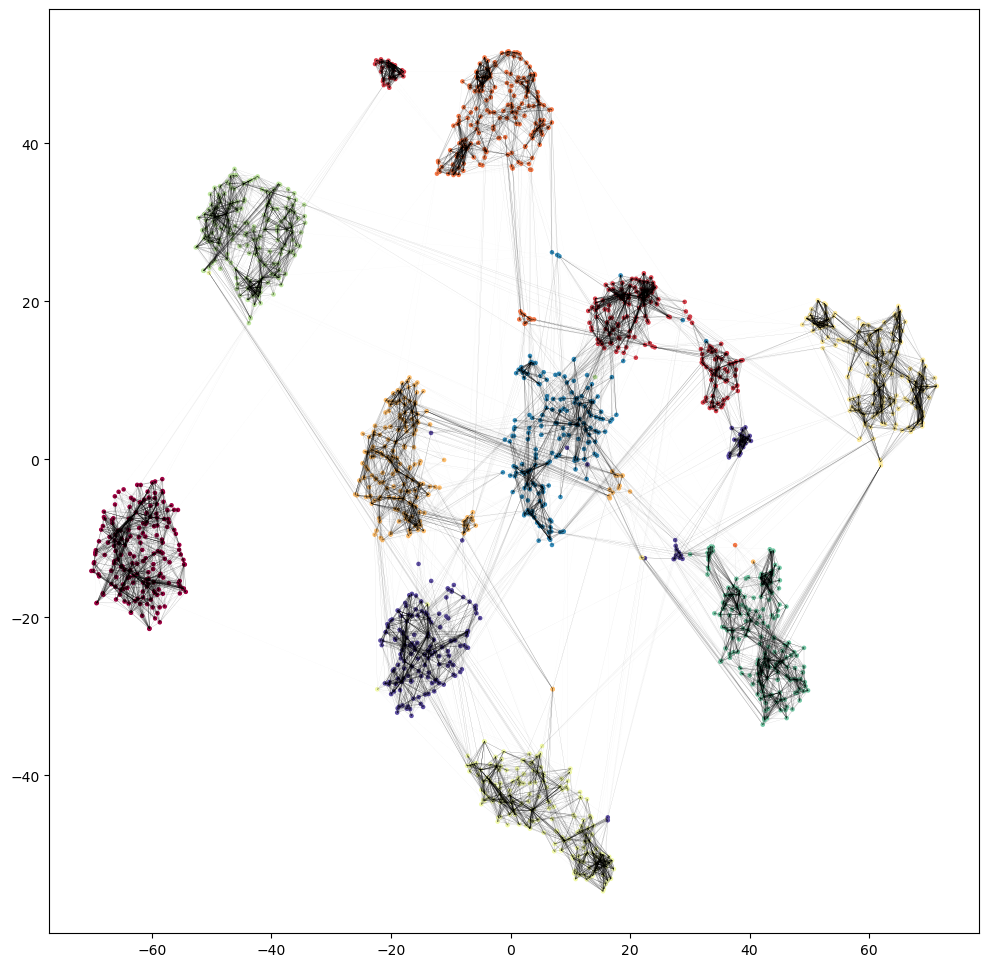

In [67]:
test = plot_graph_data(triangle_graph, tsne_map, digits.target, thickness=0.5)

In [86]:
neighborhood_graph = neighborhood_amplification(symmetric_graph)
# neighborhood_graph = normalize(neighborhood_graph, norm="l1")
neighborhood_graph.data[neighborhood_graph.data < 0.1] = 0.0
# neighborhood_graph = normalize(neighborhood_graph, norm="l1")
neighborhood_graph.eliminate_zeros()

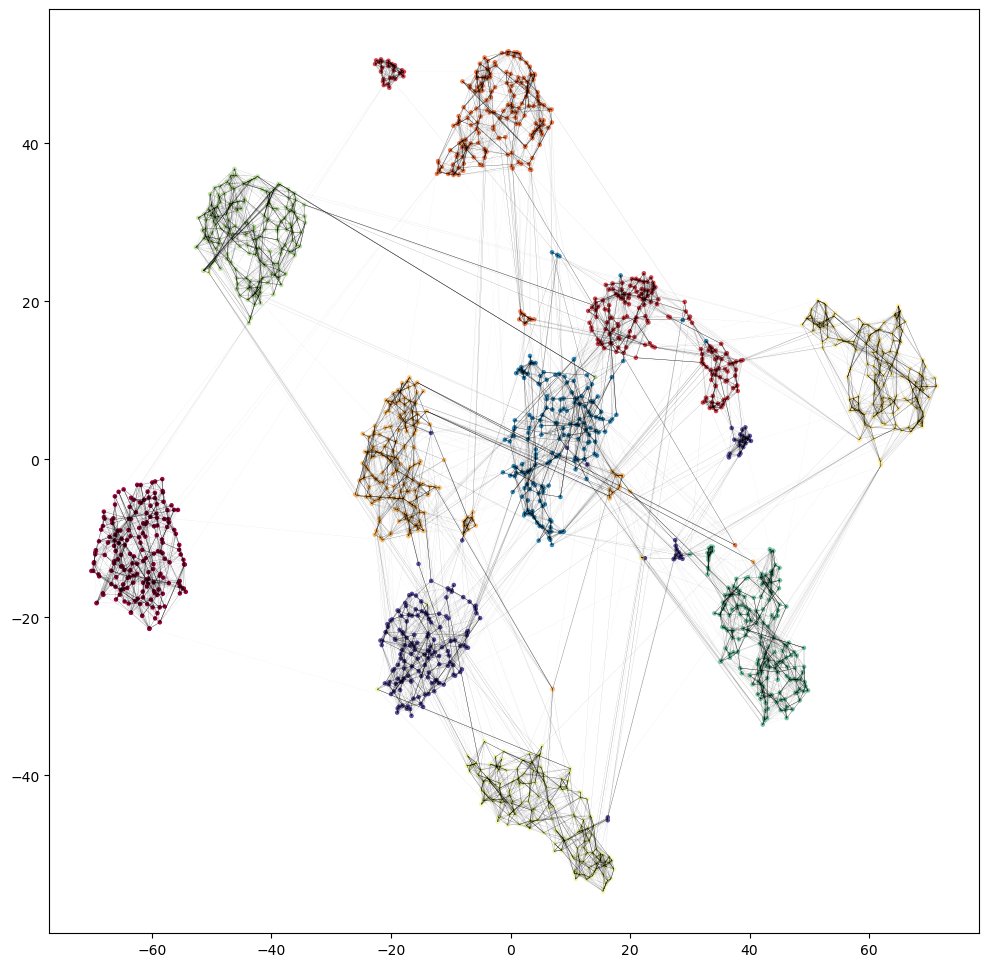

In [87]:
test = plot_graph_data(neighborhood_graph, tsne_map, digits.target, thickness=.5)

In [88]:
def laplacian_from_graph(graph):
    laplacian = -graph
    laplacian.setdiag(np.zeros(graph.shape[0]))
    laplacian.setdiag(-np.squeeze(np.asarray(laplacian.sum(axis=1))))
    return laplacian

In [89]:
def compute_omega(graph):
    laplacian = laplacian_from_graph(graph)
    laplacian_pinv = np.linalg.pinv(laplacian.toarray())
    omega = np.zeros(graph.data.shape[0])
    coo_graph = graph.tocoo()
    for n in range(coo_graph.data.shape[0]):
        i, j = coo_graph.row[n], coo_graph.col[n]
        omega[n] = laplacian_pinv[i, i] + laplacian_pinv[j, j] - laplacian_pinv[i, j] - laplacian_pinv[j, i]
            
    return omega, coo_graph

In [90]:
def compute_resistance_link_curvature(graph):
    omega, coo_graph = compute_omega(graph)
    relative_resistance = graph.copy()
    relative_resistance.data *= omega
    resistance_curvature = 1 - 0.5 * np.squeeze(np.asarray(relative_resistance.sum(axis=1)))
    resistance_link_curvature = coo_graph.copy()
    for n in range(coo_graph.data.shape[0]):
        i, j = coo_graph.row[n], coo_graph.col[n]
        if omega[n] > 0:
            resistance_link_curvature.data[n] = 2 * (resistance_curvature[i] + resistance_curvature[j]) / omega[n]
        else:
            resistance_link_curvature.data[n] = 0.0
        
    return resistance_link_curvature.tocsr()

In [91]:
def iterate_curvature_flow(graph, i):
    omega, next_graph = compute_omega(graph)
    print(omega)
    omega_scaling = (np.percentile(omega, 100 - 20 * np.power(2.0, -(i**2)/2)) - (omega))
#     omega_scaling = (np.percentile(omega, 95) - (omega))
    next_graph.data *= omega_scaling
#     next_graph.data /= omega
#     next_graph.data[omega_scaling < 0] = 0.0
#     next_graph = normalize(next_graph, norm="l1")
    next_graph.data[next_graph.data < 0] = 0.0
    next_graph = normalize(next_graph, norm="l1")# * np.log2(30)
#     next_graph /= next_graph.max()
    next_graph += next_graph.transpose()
    next_graph /= 2
#     next_graph = next_graph + next_graph.transpose() - next_graph.multiply(next_graph.transpose())
    next_graph.eliminate_zeros()
    return next_graph

In [92]:
mapper = umap.UMAP(n_neighbors=15).fit(digits.data)
graph = mapper.graph_.copy()
for i in range(5):
    graph = iterate_curvature_flow(graph, i)

/disk/home/vmpouli/.conda/envs/HighDimensionalClustering/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


[0.36132812 0.25       0.36914062 ... 0.40625    0.3671875  0.4453125 ]
[2.5    1.75   2.8125 ... 3.125  2.     2.125 ]
[2.5   2.25  3.5   ... 3.25  1.625 1.625]
[3.  2.5 4.  ... 3.5 1.5 2. ]
[3.  2.5 4.  ... 4.5 2.  2. ]


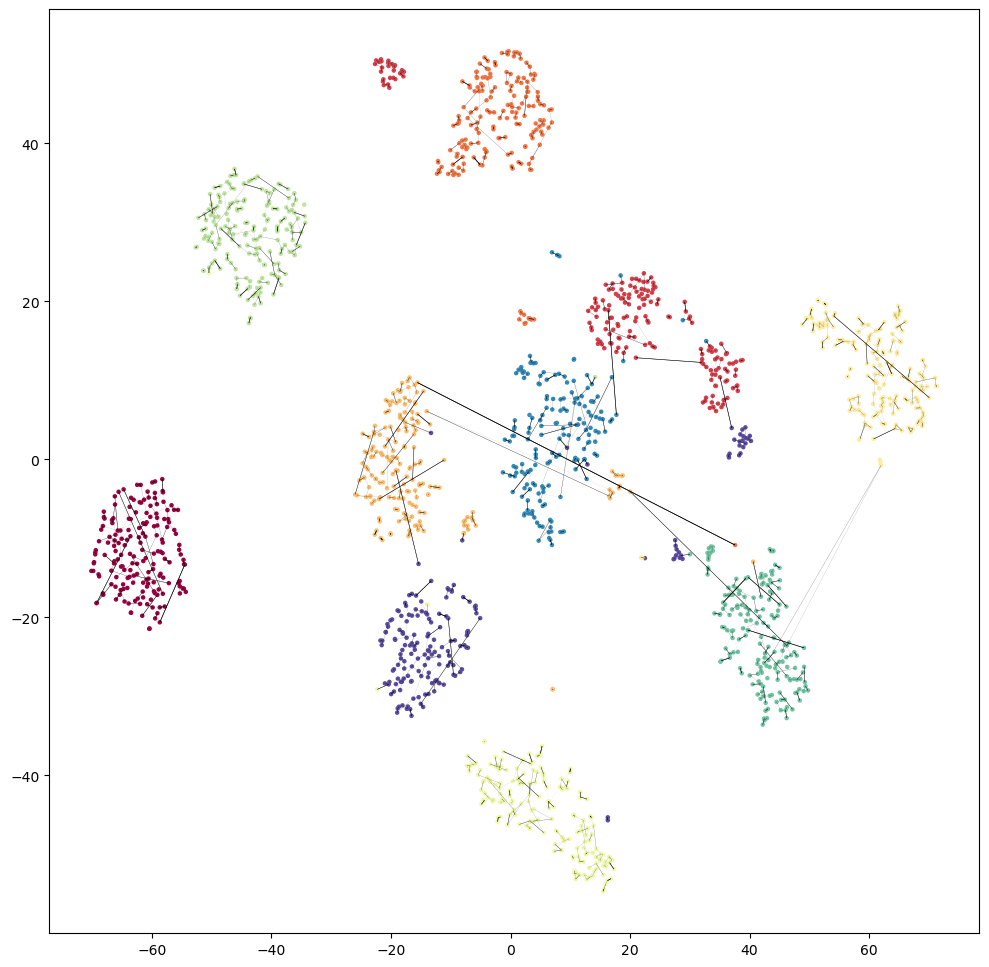

In [93]:
test = plot_graph_data(graph, tsne_map, digits.target, thickness=.5)